In [1]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
#sns.set_style("darkgrid")
#sns.set_context("poster")
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
%matplotlib inline
import sys
import os
from scipy.optimize import newton, minimize, fsolve
import numpy as np
import copy
import re

import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])

In [2]:
def RR2Asp(RR):
    return(54.611* (RR**1.0578))
def RR2Asn(RR):
    return(60.033* (RR**0.9177))

In [3]:
### Read measurements
annotation_df = pd.read_excel('annotation_df.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('Asp-levels-post-metformin_Vec-GCN2i.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['Response Ratio']) != 0:
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = metab_dict_mes[k]['Sample ID']
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['Dilution_factor']
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Flag Details'], axis=1)

In [4]:
metab_dict_mes['Uridine neg']

,Compound,RT,Sample ID,Response,Formula,Response Ratio,Sample_name,Dilution_factor,Drug,Time
0,Uridine neg,6.22,AG01,1.770001e+11,C9H12N2O6,0,AG01,0.017744,Vehicle,2
1,Uridine neg,6.22,AG02,1.646614e+11,C9H12N2O6,0,AG02,0.017744,Vehicle,2
2,Uridine neg,6.22,AG03,1.704528e+11,C9H12N2O6,0,AG03,0.017744,Vehicle,2
3,Uridine neg,6.22,AG04,1.876366e+11,C9H12N2O6,0,AG04,0.015806,1uM-GCN2i,2
4,Uridine neg,6.22,AG05,1.876427e+11,C9H12N2O6,0,AG05,0.015806,1uM-GCN2i,2
5,Uridine neg,6.22,AG06,6.695609e+10,C9H12N2O6,0,AG06,0.021511,Vehicle,6
6,Uridine neg,6.22,AG07,7.878482e+10,C9H12N2O6,0,AG07,0.021511,Vehicle,6
7,Uridine neg,6.22,AG08,7.763623e+10,C9H12N2O6,0,AG08,0.021511,Vehicle,6
8,Uridine neg,6.22,AG09,6.275014e+10,C9H12N2O6,0,AG09,0.023526,1uM-GCN2i,6
9,Uridine neg,6.22,AG10,6.963151e+10,C9H12N2O6,0,AG10,0.023526,1uM-GCN2i,6


In [5]:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']

    if 'Aspartate' in nam:
        df['Aspartate conc'] = RR2Asp(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['Dilution_factor'].values
        df['Aspartate conc'] = df['Aspartate conc'].replace(np.nan, 0)

In [6]:
df['NAD-NADH'] = (df['NAD pos'] / df['NADH pos']).replace(np.inf, np.nan)
df['GSH-GSSG'] = (df['Glutathione pos'] / df['Glutathione disulfide pos']).replace(np.inf, np.nan)

df['ATP-ADP'] = (df['ATP pos'] / df['ADP pos']).replace(np.inf, np.nan)
df['ATP-AMP'] = (df['ATP pos'] / df['AMP pos']).replace(np.inf, np.nan)
df['ADP-AMP'] = (df['ADP pos'] / df['AMP pos']).replace(np.inf, np.nan)

df['UTP-UDP'] = (df['UTP neg'] / df['UDP neg']).replace(np.inf, np.nan)
df['UTP-UMP'] = (df['UTP neg'] / df['UMP neg']).replace(np.inf, np.nan)
df['UDP-UMP'] = (df['UDP neg'] / df['UMP neg']).replace(np.inf, np.nan)




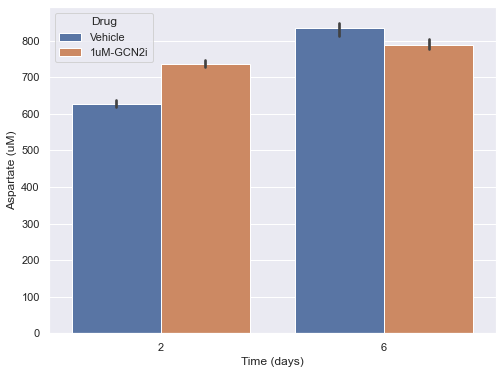

In [16]:
### Aspartate concentration ###

pdf = matplotlib.backends.backend_pdf.PdfPages('Asp_vs_time.pdf')
fig = plt.figure(figsize=(8, 6))

g = sns.barplot(data=df, x='Time', y='Aspartate conc', hue='Drug',)

plt.xlabel('Time (days)', size=12);
plt.ylabel('Aspartate (uM)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

In [11]:
df.loc[:, ['Drug', 'Time', 'Aspartate conc']]

,Drug,Time,Aspartate conc
0,Vehicle,2,626.333201
1,Vehicle,2,638.276955
2,Vehicle,2,617.383534
3,1uM-GCN2i,2,746.752150
4,1uM-GCN2i,2,726.599125
5,Vehicle,6,813.506773
6,Vehicle,6,838.763375
7,Vehicle,6,848.877735
8,1uM-GCN2i,6,785.443797
9,1uM-GCN2i,6,803.970233
